# Barclays Fantasy Football Project

### Approach

The general approach to predicting my set of 15 players for the next gameweek would thus be as follows:

1. Use the model to predict a set of top performing players for the *t-1th* gameweek, defined as players who would satisfy $Y_{t+1} =1$ and where *r* is arbitrarily defined.
2. Obtain *m* players . If *m* <15, decrease r and perform step 1 again.
3. Narrow down to 15 players using linear optimisation, with the objective of filling 15 positions subject to the constraints that there has to be 2 goalkeepers, 5 defenders, 5 midfielders and 3 forwards, and all must be fit to play in the *t+1-th* gameweek.

These are the main features in my dataset

Attributes|Type|Description
-|-|-
id|int|Unique Player ID
first_name|str| Player's First Name
second_name|str| Player's Second Name
team_name|str| Team which player belongs to
team_id|int| Unique ID number of the team that the player belongs to
type_name|str| Categorical. Whether the player is a Goalkeeper, Defender, Midfielder or Forward
now_cost|int| Cost of player in £100,000 in the *t-th* gameweek
cost_t1|int| Cost of player in £100,000 in the *t-1th* gameweek
chance_of_playing_next_round|float| Percentage likelihood that the player will play in the *t+1th* gameweek
chance_of_playing_this_round|float| Percentage likelihood that the player will play in the *tth* gameweek
minutes|int| Total number of minutes played up to the *t-th* gameweek
form|float64| A player's form, as calculated by BPL over the last 30 days in the latest gameweek. 
bonus_form_t1|int| The sum of a player's bonus points for the *t-6th* to the *t-1th* gameweek
fantasy_form_t1|int| The sum of a player's fantasy points for the *t-6th* to the *t-1th* gameweek
own_team_form|int| Total number of points that the player's team has garnered from the *t-6th* to the *t-1th* gameweek
home|boolean| Whether the *t-th* game will be played at the player's team home stadium
next_team_t|str| The name of the team that the player is up against in the *t-th* week
next_team_pos|int| The league position of the team that that the player is up against in the *t-th* week

I'll be focusing on the bottom 6 features for my model. 

In [6]:
required_fields=['id','first_name','second_name','team_name','team_id','type_name','now_cost','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form']
print (len(required_fields))
full_fields = ['id','first_name','second_name','team_name','team_id','type_name','now_cost','chance_of_playing_next_round','chance_of_playing_this_round','minutes','form','bonus_form_t1','fantasy_form_t1','cost_t1','minutes_t1','goals_t1','assists_t1','clean_sheets_t1','goals_conceded_t1','saves_t1','bonus_per_min_t1', 'pts_per_min_t1','goals_per_min_t1', 'assists_per_min_t1', 'clean_sheets_per_min_t1','goals_conceded_per_min_t1','saves_per_min_t1','own_team_form','own_team_pos_t','home','next_team','next_team_pos_t','fantasy_points_t']
print (len(full_fields))

11
33


In [2]:
import re 
import requests as rq
import csv 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [7]:
import json



In [11]:
d = []
for i in range(1,551):
    r = rq.get('http://fantasy.premierleague.com/web/api/elements/%d' %(i)) ## Pulls data from the api ##
    R = r.json()
    d.append(R)
with open('data.json', 'w') as fp:
    json.dump(d, fp)

In [8]:
with open("data.json") as json_file:
    json_data = json.load(json_file)
    

In [279]:
team_codes = [ json_data[i]['team_code'] for i in range(len(json_data))] 


set

In [9]:
## This bit extracts the league positions for each team from GW26 to GW1 ##

TeamPositions= {}
TeamIndex=[1,3,4,6,7,8,11,13,14,20,21,31,35,43,45,56,57,80,91,110]
for i in TeamIndex:
    d=rq.get('http://www.premierleague.com/ajax/league-table/date-timeline/expanded/2015-2016/28-02-2016/%d/CLUB.json' %(i))
    D=d.json()
    TeamPos = [d['Pos'] for d in D['clubDetails']['performance']]
    TeamName = D['clubDetails']['playersToWatch']['byRatingType']['EA_SPORTS_PLAYER_PERFORMANCE_INDEX'][0]['club']['clubCode']
    TeamPositions[TeamName]=TeamPos
    


In [11]:
## Just some cleaning to sort out the ordering 

teamids=(np.unique([json_data[i]['team_name'] for i in range(len(json_data))])).tolist()
teamids[12:17] = [u'Southampton',u'Sunderland',u'Stoke',u'Swansea',u'Spurs']


{u'ARS': [20,
  11,
  9,
  5,
  3,
  5,
  4,
  2,
  2,
  1,
  2,
  2,
  4,
  4,
  2,
  1,
  2,
  2,
  1,
  1,
  1,
  1,
  3,
  4,
  3,
  3,
  3],
 u'AVL': [3,
  7,
  12,
  12,
  15,
  17,
  18,
  18,
  18,
  19,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20,
  20],
 u'BOU': [17,
  19,
  10,
  11,
  15,
  11,
  16,
  15,
  17,
  17,
  17,
  18,
  18,
  18,
  17,
  14,
  14,
  14,
  16,
  15,
  16,
  15,
  15,
  15,
  15,
  15,
  15],
 u'CHE': [5,
  16,
  9,
  13,
  16,
  13,
  15,
  16,
  11,
  15,
  15,
  16,
  15,
  14,
  14,
  16,
  15,
  15,
  14,
  14,
  14,
  14,
  13,
  13,
  13,
  12,
  11],
 u'CRY': [2,
  6,
  4,
  2,
  4,
  8,
  6,
  3,
  6,
  6,
  8,
  8,
  10,
  6,
  6,
  6,
  6,
  5,
  5,
  7,
  7,
  8,
  11,
  11,
  12,
  13,
  14],
 u'EVE': [6,
  3,
  7,
  9,
  5,
  6,
  5,
  7,
  9,
  10,
  9,
  8,
  7,
  7,
  9,
  9,
  10,
  9,
  11,
  11,
  11,
  11,
  12,
  11,
  8,
  10],
 u'LEI': [1,
  1,
  1,
  3,
  2,
  3,
  6,
  4,

In [12]:
## I need this dict to give the short form team names in my dataframe later##

tkeys = sorted(TeamPositions.keys())
team_map={teamids[i]:tkeys[i] for i in range(len(tkeys))}

team_map['Stoke']=u'STK'
team_map['Sunderland']=u'SUN'


In [20]:
## This function will give extract features for a given gameweek and a certain lag ## 

def generate_gw_data(gw,lag,json_data):
    data=[]
    t_form=[]
    for i in range(0,549):
        p_data = [json_data[i][required_fields[j]] for j in range(len(required_fields))] ## These "required fields" are the player id, name, team name etc. ##
        p_hist = json_data[i]['fixture_history']['all'] ## This contains the fixture history of the i-th player amongst 550 players.##
        
        ## Form variables are the sum of points from gw-1th to the (gw-1-lag)th gameweek. These are individual performance attributes## 
        
        bonus_form_t1 = float(sum([p_hist[j][16] for j in range((gw-1-lag),(gw-1))]))
        fantasy_form_t1 = float(sum([p_hist[j][19] for j in range((gw-1-lag),(gw-1))]))  
        minutes_t1 = float(sum([p_hist[j][3] for j in range((gw-1-lag),(gw-1))]))
        goals_t1 = float(sum([p_hist[j][4] for j in range((gw-1-lag),(gw-1))]))
        assists_t1 = float(sum([p_hist[j][5] for j in range((gw-1-lag),(gw-1))]))
        clean_sheets_t1 = float(sum([p_hist[j][6] for j in range((gw-1-lag),(gw-1))]))
        goals_conceded_t1 = float(sum([p_hist[j][7] for j in range((gw-1-lag),(gw-1))]))
        saves_t1= float(sum([p_hist[j][13] for j in range((gw-1-lag),(gw-1))]))
        cost_t1 = p_hist[gw-1][18]

        ## Per minute features##
        
        if minutes_t1>0:
            bonus_per_min_t1 = bonus_form_t1/minutes_t1
            pts_per_min_t1 = fantasy_form_t1/minutes_t1
            goals_per_min_t1 = goals_t1/minutes_t1
            assists_per_min_t1 = assists_t1/minutes_t1
            clean_sheets_per_min_t1 = clean_sheets_t1/minutes_t1
            goals_conceded_per_min_t1 = goals_conceded_per_min_t1/minutes_t1
            saves_per_min_t1=saves_t1/minutes_t1
        else:
            bonus_per_min_t1 = pts_per_min_t1 = goals_per_min_t1 = assists_per_min_t1 = clean_sheets_per_min_t1 = goals_conceded_per_min_t1 = saves_per_min_t1= 0
        
        ## Team Performance Attributes ##
        for j in range((gw-1-lag),(gw-1)):
            g= re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[j][2])
            if g.groups()[2]==g.groups()[3]:
                result=1
            elif g.groups()[2]>g.groups()[3]:
                result = 3
            elif g.group()[2]<g.groups()[3]:
                result =0
        t_form.append(result)
        own_team_form=sum(t_form) # use regex to derive the "team form" feature#
        own_team_pos_t= TeamPositions[team_map[json_data[i]['team_name']]][gw]
        next_team=json_data[i]['fixture_history']['all'][gw][2].split()[0][0:3]
        next_team_pos_t= TeamPositions[next_team][gw]
        t_form=[]
        home = re.match("(.*)(...) ([0-9]+)?-?([0-9]+)",p_hist[gw][2]).groups()[1] == '(H)'
                
        ## Outcome variable ## 
        
        fantasy_points_t=json_data[i]['fixture_history']['all'][gw][19] 
        
        ## Putting them all together ##
        
        p_data.extend([bonus_form_t1,fantasy_form_t1,cost_t1,minutes_t1,goals_t1,assists_t1,clean_sheets_t1,goals_conceded_t1,saves_t1,bonus_per_min_t1, pts_per_min_t1,goals_per_min_t1, assists_per_min_t1, clean_sheets_per_min_t1,goals_conceded_per_min_t1,saves_per_min_t1,own_team_form,own_team_pos_t,home,next_team,next_team_pos_t,fantasy_points_t])
        data.append(p_data)
        
    df = pd.DataFrame(data=data,columns=full_fields) # convert to pandas dataframe
    return df


In [144]:
GW6= generate_gw_data(6,5,json_data)
GW7= generate_gw_data(7,5,json_data)


In [329]:

y = pd.DataFrame()
gw_6= GW6[GW6.minutes!=0]
gw_6= gw_6[gw_6.type_name=="Forward"]

gw6.join((pd.DataFrame({'moo':gw7_fwd_pred, 'moo2':gw7_fwd_pred},index=gw_6.index)),how='right').sort_values(by="moo",ascending=False).head(10)


,id,first_name,second_name,team_name,team_id,type_name,now_cost,chance_of_playing_next_round,chance_of_playing_this_round,minutes,...,goals_conceded_per_min_t1,saves_per_min_t1,own_team_form,own_team_pos_t,home,next_team,next_team_pos_t,fantasy_points_t,moo,moo2
169,170,Jamie,Vardy,Leicester,7,Forward,78,100,100,2538,...,0,0,3,6,True,ARS,4,12,8.915,8.915
484,485,Diafra,Sakho,West Ham,20,Forward,62,100,100,1075,...,0,0,3,3,True,NOR,13,6,6.930,6.930
320,321,Graziano,Pellè,Southampton,13,Forward,78,100,100,1681,...,0,0,1,9,True,SWA,11,8,6.355,6.355
73,74,Callum,Wilson,Bournemouth,3,Forward,53,0,0,541,...,0,0,1,16,False,STK,17,1,6.355,6.355
148,149,Romelu,Lukaku,Everton,6,Forward,88,100,100,2419,...,0,0,3,5,False,WBA,15,16,5.440,5.440
416,417,Bafétimbi,Gomis,Swansea,17,Forward,63,100,100,1459,...,0,0,3,11,False,SOU,9,1,4.650,4.650
392,393,Steven,Fletcher,Sunderland,16,Forward,48,0,0,1010,...,0,0,1,20,False,MUN,1,1,4.455,4.455
272,273,Ayoze,Pérez Gutiérrez,Newcastle,11,Forward,51,NaN,NaN,1589,...,0,0,1,19,True,CHE,15,12,4.360,4.360
530,531,Rudy,Gestede,Aston Villa,2,Forward,55,100,100,1223,...,0,0,1,18,False,LIV,7,13,4.335,4.335
150,151,Arouna,Koné,Everton,6,Forward,44,NaN,NaN,1314,...,0,0,3,5,False,WBA,15,4,4.240,4.240


In [359]:
##Drop redundant players who have played 0 minutes up to GW 6. 

type_name=["Goalkeeper","Defender","Midfielder","Forward"]

### These are features/attributes that are relevant to the position that they're playing ##  
fwd_attributes=['bonus_form_t1','fantasy_form_t1','minutes_t1','goals_t1','assists_t1','bonus_per_min_t1','pts_per_min_t1','goals_per_min_t1','assists_per_min_t1','own_team_form', 'own_team_pos_t','home', 'next_team_pos_t']
mf_attributes=fwd_attributes + ['clean_sheets_t1','clean_sheets_per_min_t1']
def_attributes = mf_attributes + ['goals_conceded_t1','goals_conceded_per_min_t1']
gk_attributes= def_attributes + ['saves_t1','saves_per_min_t1']
attributes = [gk_attributes,def_attributes,mf_attributes,fwd_attributes]
personal_attributes = ['id','first_name','second_name','team_name','team_id','type_name','cost_t1']
attrkeys = dict(zip(type_name,attributes))



In [347]:
## This function returns a dataframe of 35 players with the highest predicted scores. 5 GKs, 10 DFs, MFs and FWs. ##
def gen_top_35_players(gw,lag,json_data,max_depth=None,ntrees=20):

    gw_t=generate_gw_data(gw,lag,json_data)
    gw_t1=generate_gw_data(gw+1,lag,json_data)

    ## Remove inactive players ## 

    GW_t=gw_t[gw_t.minutes!=0]
    GW_t1=gw_t1[gw_t1.minutes!=0]
    top35=pd.DataFrame()
    for pos in type_name:
        ## Subset the data for each position ## 
        GW_t_sub=GW_t[GW_t.type_name==pos]
        GW_t1_sub=GW_t1[GW_t1.type_name==pos]

        ## Create relevant feature set and response variable for t-th and t+1-th gameweek ## 
        X_t= GW_t_sub[attrkeys[pos]]
        y_t1= GW_t_sub.fantasy_points_t
        X_t1= GW_t1_sub[attrkeys[pos]]
        y_t2=GW_t1_sub.fantasy_points_t

        ## Fit the Random Forest Regressor ## 

        rfr= RandomForestRegressor(n_estimators=ntrees,random_state=1,max_depth=max_depth)
        rfr_gw=rfr.fit(X_t,y_t1)
        y_t2_hat =rfr_gw.predict(X_t1)
        pred_errors = y_t2_hat-y_t2
        if pos != "Goalkeeper":
            top35= top35.append(GW_t_sub[personal_attributes].join((pd.DataFrame({'predictions':y_t2_hat,'actual':y_t2, 'errors':pred_errors},index=GW_t_sub[personal_attributes].index)),how='right').sort_values(by="predictions",ascending=False).head(10))
        else:
            top35= top35.append(GW_t_sub[personal_attributes].join((pd.DataFrame({'predictions':y_t2_hat,'actual':y_t2, 'errors':pred_errors},index=GW_t_sub[personal_attributes].index)),how='right').sort_values(by="predictions",ascending=False).head(5))
        
    return top35
    ## 
        


In [354]:
gw_preds=gen_top_35_players(gw=6,lag=5,json_data=json_data)
gw_preds.to_csv("Gameweek 7 Predictions.csv",encoding="utf")
## Export to csv so I can do the linear optimisation in R ## 

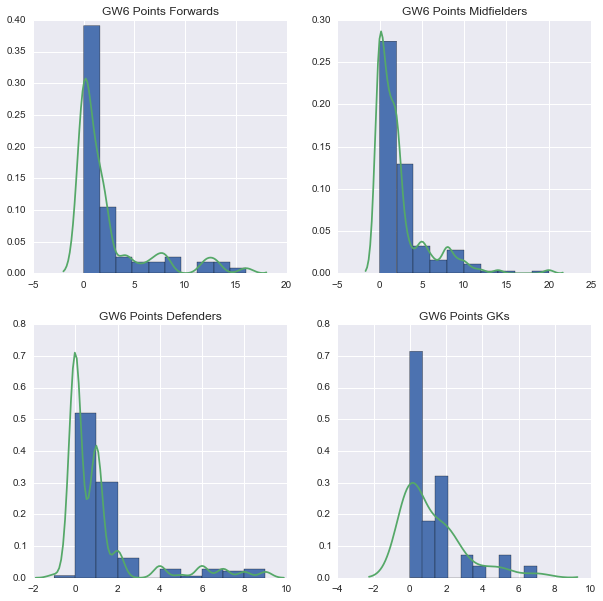

In [163]:
plt.subplots(nrows=2,ncols=2,sharex=True,figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(np.asarray(gw6_fwd.fantasy_points_t),normed=True)
sns.kdeplot(np.asarray(gw6_fwd.fantasy_points_t))
plt.title("GW6 Points Forwards")
plt.subplot(2,2,2)
plt.hist(np.asarray(gw6_mf.fantasy_points_t),normed=True)
sns.kdeplot(np.asarray(gw6_mf.fantasy_points_t))
plt.title("GW6 Points Midfielders")
plt.subplot(2,2,3)
plt.hist(np.asarray(gw6_def.fantasy_points_t),normed=True)
sns.kdeplot(np.asarray(gw6_def.fantasy_points_t))
plt.title("GW6 Points Defenders")
plt.subplot(2,2,4)
plt.hist(np.asarray(gw6_gk.fantasy_points_t),normed=True)
sns.kdeplot(np.asarray(gw6_gk.fantasy_points_t))
plt.title("GW6 Points GKs")

In [194]:
## Create new feature set and define new binary outcome variable

X_fwd_t1= gw7_fwd[fwd_attributes]
y_fwd_t1= gw7_fwd.fantasy_points_t
X_fwd_t = gw6_fwd[fwd_attributes]
y_fwd_t = gw6_fwd.fantasy_points_t


In [248]:
predlabs= ["Predicted Score","Actual Score","Residual"]
gw7_fwd_pred =rfr_gw6.predict(X_fwd_t1)
gw7_fwd_true = y_fwd_t1
gw7_fwd_errors = gw7_fwd_true-gw7_fwd_pred



array([ 2.85      ,  0.445     ,  3.91      ,  2.98      ,  0.28816667,
        6.355     ,  1.255     ,  0.50891667,  3.14      ,  2.385     ,
        1.02      ,  1.        ,  1.8725    ,  2.125     ,  1.4245    ,
        5.44      ,  2.69      ,  4.24      ,  8.915     ,  0.98333333,
        0.565     ,  4.055     ,  0.91833333,  1.855     ,  2.36      ,
        0.715     ,  0.32833333,  4.055     ,  2.735     ,  0.6825    ,
        4.09      ,  0.22333333,  3.49      ,  4.36      ,  0.595     ,
        2.425     ,  1.22      ,  2.06      ,  0.71      ,  2.57833333,
        1.51333333,  6.355     ,  0.96808333,  0.15925   ,  4.01      ,
        1.6175    ,  3.24      ,  1.92      ,  1.89      ,  2.375     ,
        3.9       ,  4.455     ,  2.835     ,  4.65      ,  0.687     ,
        1.08      ,  1.205     ,  2.915     ,  4.21      ,  0.085     ,
        1.75      ,  1.99333333,  2.61108333,  6.93      ,  1.30583333,
        1.4575    ,  1.195     ,  1.465     ,  1.52833333,  4.33

In [94]:
range(len(fwd_attributes))



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

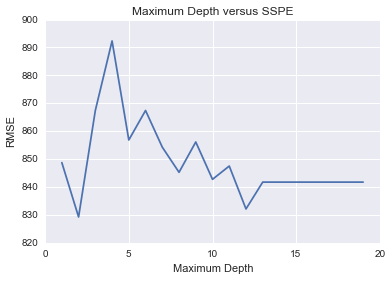

In [149]:
Cp_vec=[]
mse_vec=[]
sspe_vec=[]
rfr20=RandomForestRegressor(n_estimators=100,random_state=1,max_depth=20).fit(X_fwd_t,y_fwd_t)
s2= sum((y_fwd_t1-rfr20.predict(X_fwd_t1))**2)

for i in range(1,20):
    rfr = RandomForestRegressor(n_estimators=10,max_depth=i,random_state=1).fit(X_fwd_t,y_fwd_t)
    sspe= sum((y_fwd_t1-rfr.predict(X_fwd_t1))**2)
    sspe_vec.append(sspe)
    

plt.plot(range(1,20),sspe_vec)
plt.title("Maximum Depth versus SSPE")
plt.xlabel("Maximum Depth")
plt.ylabel("Sum of Squared Prediction Error")


